In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear

import torch_geometric.nn as pyg_nn
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True)
torch.set_printoptions(precision=5, sci_mode=False)

In [2]:
def slice_dataset(dataset_in, percentage):
    data_size = len(dataset_in)
    index = [i for i in range(len(dataset))]
    np.random.shuffle(index)
    dataset_random = dataset_in[index,:]
    return dataset_random[:int(data_size*percentage/100)],dataset_random[int(data_size*percentage/100):]

def make_dataset(dataset, n_bus):
    x_raw_1, y_raw_1 = [], []
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        y_raw_1=[dataset[i,4800]]
        for n in range(n_bus):
            x_raw_1.append(list(dataset[i,200*n:200*n+200])) 
        
        x_raw.append(list(x_raw_1))
        y_raw.append(y_raw_1)
        x_raw_1, y_raw_1 = [], []

    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw


def NRMSE(yhat,y):
    return torch.sqrt(torch.mean(((yhat-y)/torch.std(yhat,0))**2))

def MSE(yhat,y):
    return torch.mean((yhat-y)**2)

In [3]:
dataset = pd.read_excel('train_3rd_wr.xlsx').values

In [4]:
dataset_0 = np.zeros([1100,4801])
#dataset_10b=np.concatenate((dataset[:,0:400],dataset[:,600:800],dataset[:,1000:1800],dataset[:,2000:2200],dataset[:,2400:2600],dataset[:,2600:3000],dataset[:,3200:3400],dataset[:,3600:4400],dataset[:,4600:4800],dataset[:,5000:5201]),axis=1)
#RoCoF Features
#dataset_0[:,0:200]=dataset[:,2600:2800] # bus 1 nodal features
dataset_0[:,200:400]=dataset[:,2800:3000] # bus 2 nodal features
dataset_0[:,2400:2600]=dataset[:,3200:3400] # bus 13 nodal features
dataset_0[:,3000:3200]=dataset[:,3800:4000] # bus 16 nodal features
#dataset_0[:,3400:3600]=dataset[:,4000:4200] # bus 18 nodal features
dataset_0[:,4000:4200]=dataset[:,4200:4400] # bus 21 nodal features
dataset_0[:,4400:4600]=dataset[:,4800:5000] # bus 22,23 nodal features
dataset_0[:,4800:4801]=dataset[:,5200:5201] # labels
print(dataset_0[0])

[0.  0.  0.  ... 0.  0.  3.5]


In [5]:
train_percentage = 80
val_percentage = 20

print(dataset.shape)
train_dataset,val_dataset  = slice_dataset(dataset_0, train_percentage)
#val_dataset = slice_dataset(dataset_0, val_percentage)

n_bus = 24

#actual data
x_raw_train, y_raw_train = make_dataset(train_dataset,n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

(1100, 5201)


In [6]:
y_raw_train

tensor([[3.50000],
        [4.00000],
        [5.50000],
        [7.00000],
        [8.00000],
        [6.00000],
        [7.50000],
        [7.50000],
        [5.50000],
        [8.00000],
        [4.00000],
        [6.50000],
        [7.00000],
        [4.50000],
        [8.00000],
        [8.00000],
        [6.50000],
        [3.00000],
        [7.50000],
        [4.00000],
        [6.50000],
        [4.50000],
        [7.00000],
        [6.00000],
        [7.00000],
        [7.00000],
        [6.50000],
        [3.00000],
        [5.50000],
        [3.00000],
        [4.00000],
        [4.50000],
        [7.50000],
        [6.00000],
        [6.00000],
        [5.50000],
        [7.50000],
        [3.00000],
        [3.00000],
        [5.50000],
        [7.50000],
        [8.00000],
        [8.00000],
        [4.00000],
        [5.00000],
        [4.00000],
        [4.50000],
        [5.00000],
        [4.00000],
        [6.00000],
        [3.50000],
        [5.50000],
        [6.0

In [7]:
x_train, y_train = x_raw_train, y_raw_train
x_val, y_val = x_raw_val, y_raw_val
edge_index = torch.tensor([[0, 1, 0, 2, 0, 4, 1, 3, 1, 5, 2, 8, 2,23, 3, 8, 4, 9, 5, 9, 6, 7, 7, 8, 7, 9, 8,10, 8,11, 9,10, 9,11,10,12,10,13,11,12,11,22,12,22,13,15,14,15,14,20,14,23,15,16,15,18,16,17,16,21,17,20,18,19,19,22,20,21],
                           [1, 0, 2, 0, 4, 0, 3, 1, 5, 1, 8, 2,23, 2, 8, 3, 9, 4, 9, 5, 7, 6, 8, 7, 9, 7,10, 8,11, 8,10, 9,11, 9,12,10,13,10,12,11,22,11,22,12,15,13,15,14,20,14,23,14,16,15,18,15,17,16,21,16,20,17,19,18,22,19,21,20]], dtype=torch.long)

data_train_list, data_val_list = [], []
for i,_ in enumerate(x_train):
    data_train_list.append(Data(x=x_train[i], y=y_train[i], edge_index=edge_index))
for i,_ in enumerate(x_val):
    data_val_list.append(Data(x=x_val[i], y=y_val[i], edge_index=edge_index))

train_loader = DataLoader(data_train_list, batch_size=1)
val_loader = DataLoader(data_val_list, batch_size=1)

D:\Anaconda\envs\python38\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
class My_GNN_NN(torch.nn.Module):
    def __init__(self, node_size=None, feat_in=None, feat_size1=None, hidden_size1=None, output_size=None):
        super(My_GNN_NN, self).__init__()
        self.feat_in = feat_in if feat_in is not None else 200
        self.feat_size1 = feat_in if feat_in is not None else 64
        self.hidden_size1 = hidden_size1 if hidden_size1 is not None else 64
        self.output_size = output_size if output_size is not None else 1
        
        self.conv1 = GCNConv(feat_in, feat_size1)
        self.lin1 = Linear(node_size*feat_size1, hidden_size1)
        self.lin2 = Linear(hidden_size1, output_size)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.tanh(x)

        x = x.flatten(start_dim = 0)
        x = self.lin1(x)
        x = torch.tanh(x)

        x = self.lin2(x)

        return x
    
    def save_weights(self, model, name):
        torch.save(model, name)

In [9]:
feat_in = 200
feat_size1 = 64
hidden_size1 = 64
output_size = 1
lr = 0.0001

model = My_GNN_NN(n_bus, feat_in, feat_size1, hidden_size1, output_size)
for name, param in model.named_parameters():
  print(name)
  print(param.size())

param = sum(p.numel() for p in model.parameters() if p.requires_grad)
param

conv1.bias
torch.Size([64])
conv1.lin.weight
torch.Size([64, 200])
lin1.weight
torch.Size([64, 1536])
lin1.bias
torch.Size([64])
lin2.weight
torch.Size([1, 64])
lin2.bias
torch.Size([1])


111297

In [10]:
feat_in = 200
feat_size1 = 64
hidden_size1 = 64
output_size =1
lr = 0.001

model = My_GNN_NN(n_bus, feat_in, feat_size1, hidden_size1, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loss_list, val_loss_list = [], []

count=0
patience=2000
lossMin = 1e10
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for epoch in range(2001):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y_train_prediction = model(batch)
        loss = MSE(y_train_prediction, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss=0
    for batch in val_loader:
        y_val_prediction = model(batch)
        loss = MSE(y_val_prediction, batch.y)
        val_loss += loss.item() * batch.num_graphs
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    #early stopping
    if (val_loss < lossMin):
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss
        model.save_weights(model, "Inertia_GNN_NN_model.pt")
    else:
        count+=1
        if(count>patience):
            print("early stop at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
            print("best val at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(best_epoch, best_train_loss, best_val_loss))
            break
    
    if (train_loss <= 0):
        print("min train loss at epoch {:d}    train loss: {:.7f}    val loss: {:.7f}".format(epoch, train_loss, val_loss))
        break

    if (epoch % 10) == 0:
        print('epoch: {:d}    train loss: {:.7f}    val loss: {:.7f}'.format(epoch, train_loss, val_loss))

epoch: 0    train loss: 2.8204839    val loss: 2.5021915
epoch: 10    train loss: 2.6027925    val loss: 2.4999095
epoch: 20    train loss: 0.0586028    val loss: 0.0812420
epoch: 30    train loss: 0.0303462    val loss: 0.0547229
epoch: 40    train loss: 0.0171581    val loss: 0.0477991
epoch: 50    train loss: 0.0107767    val loss: 0.0402777
epoch: 60    train loss: 0.0070486    val loss: 0.0371322
epoch: 70    train loss: 0.0051389    val loss: 0.0265033
epoch: 80    train loss: 0.0056159    val loss: 0.0361994
epoch: 90    train loss: 0.0212294    val loss: 0.0265386
epoch: 100    train loss: 0.0017746    val loss: 0.0373461
epoch: 110    train loss: 0.0034988    val loss: 0.0316771
epoch: 120    train loss: 0.0066225    val loss: 0.0312897
epoch: 130    train loss: 0.0049163    val loss: 0.0314205
epoch: 140    train loss: 0.0099325    val loss: 0.0303056
epoch: 150    train loss: 0.0010673    val loss: 0.0360982
epoch: 160    train loss: 0.0022973    val loss: 0.0313410
epoch: 1

epoch: 1390    train loss: 0.0021931    val loss: 0.0418801
epoch: 1400    train loss: 0.0115255    val loss: 0.0755107
epoch: 1410    train loss: 0.0018853    val loss: 0.0370198
epoch: 1420    train loss: 0.0053852    val loss: 0.0317300
epoch: 1430    train loss: 0.0005507    val loss: 0.0347071
epoch: 1440    train loss: 0.0005936    val loss: 0.0342895
epoch: 1450    train loss: 0.0064479    val loss: 0.0346722
epoch: 1460    train loss: 0.0006895    val loss: 0.0336098
epoch: 1470    train loss: 0.0064589    val loss: 0.0436805
epoch: 1480    train loss: 0.0012372    val loss: 0.0373359
epoch: 1490    train loss: 0.0006957    val loss: 0.0333354
epoch: 1500    train loss: 0.0015283    val loss: 0.0312483
epoch: 1510    train loss: 0.0073718    val loss: 0.0431883
epoch: 1520    train loss: 0.0063426    val loss: 0.0550247
epoch: 1530    train loss: 0.0015720    val loss: 0.0379481
epoch: 1540    train loss: 0.0020319    val loss: 0.0378780
epoch: 1550    train loss: 0.0034998    

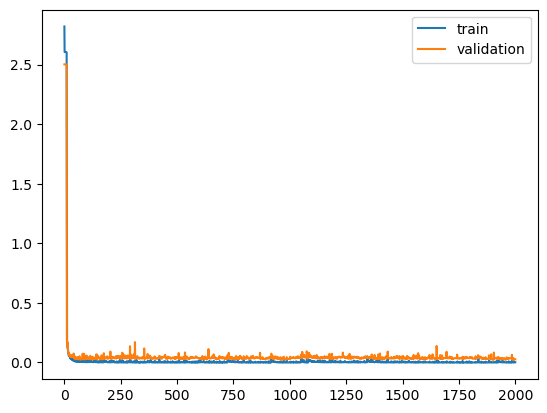

last epoch: 2000, train loss: 0.0016782, val loss: 0.0267332
best epoch: 1989, train loss: 0.0006502, val loss: 0.0212564


In [11]:
import matplotlib.pyplot as plt
#plt.title('GNN NN on power flow dataset')
plt.plot(train_loss_list, label="train")
plt.plot(val_loss_list, label="validation")
#plt.yscale('log')
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
plt.legend(loc='best')
#plt.savefig('GNN_training.png',dpi=1000)
plt.show()

print('last epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(epoch, train_loss, val_loss))
print('best epoch: {:d}, train loss: {:.7f}, val loss: {:.7f}'.format(best_epoch, best_train_loss, best_val_loss))

In [ ]:
model.eval()

y_train_prediction_1 = model(train_loader.dataset[0])
train_loss_1 = MSE(y_train_prediction_1, y_raw_train[0])
print("[1 datapoint] Train output ground-truth: \n" + str(y_raw_train[0].detach().numpy()))
print("[1 datapoint] Train output prediction: \n" + str(y_train_prediction_1.detach().numpy()))
print('[1 datapoint] Train loss (MSE): {:.7f}'.format(train_loss_1))

train_loss = 0
for batch in train_loader:
    pred = model(batch)
    loss = MSE(pred, batch.y)
    train_loss += loss.item() * batch.num_graphs
train_loss /= len(train_loader.dataset)
print('Train loss (MSE): {:.7f}'.format(train_loss))

print("=========================================================================")

y_val_prediction_1 = model(val_loader.dataset[0])
val_loss_1 = MSE(y_val_prediction_1, y_raw_train[0])
print("[1 datapoint] Val output ground-truth: \n" + str(y_raw_val[0].detach().numpy()))
print("[1 datapoint] Val output prediction: \n" + str(y_val_prediction_1.detach().numpy()))
print('[1 datapoint] Val loss (MSE): {:.7f}'.format(val_loss_1))